In [1]:
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
buoy = '42012'
ndbc.available_data('swdir', buoy)

,id,year,filename
312,42012,2009,42012d2009.txt.gz
313,42012,2010,42012d2010.txt.gz
314,42012,2011,42012d2011.txt.gz
315,42012,2012,42012d2012.txt.gz
316,42012,2013,42012d2013.txt.gz
317,42012,2014,42012d2014.txt.gz
318,42012,2015,42012d2015.txt.gz
319,42012,2016,42012d2016.txt.gz
320,42012,2017,42012d2017.txt.gz
321,42012,2018,42012d2018.txt.gz


In [3]:
# parameters = ndbc.directional_parameters

In [4]:
year = '2021'
seps = {'swden' : 'w',
        'swdir' : 'd',
        'swdir2' : 'i',
        'swr1' : 'j',
        'swr2' : 'k',
       }

data_dict = {}

for param in ndbc.directional_parameters:
    file = f'{buoy}{seps[param]}{year}.txt.gz'
    raw_data = ndbc.request_data(param, pd.Series([file,]))[str(year)]
    pd_data = ndbc.to_datetime_index(param, raw_data)

    xr_data = xr.DataArray(pd_data)
    xr_data = xr_data.astype(float).rename({'dim_1': 'frequency',})
    if param in ['swr1', 'swr2']:
        xr_data = xr_data/100.0
    xr_data.frequency.attrs = {
        'units': 'Hz',
        'long_name': 'frequency', 
        'standard_name': 'f', 
    }
    xr_data.date.attrs = {
        'units': '',
        'long_name': 'datetime', 
        'standard_name': 't', 
    }
    data_dict[param] = xr_data
    
data_dict['swden'].attrs = {
    'units': 'm^2/Hz',
    'long_name': 'omnidirecational spectrum', 
    'standard_name': 'S', 
    'description': 'Omnidirectional *sea surface elevation variance (m^2)* spectrum (/Hz).'
}

data_dict['swdir'].attrs = {
    'units': 'deg',
    'long_name': 'mean wave direction', 
    'standard_name': 'α1', 
    'description': 'Mean wave direction.'
}

data_dict['swdir2'].attrs = {
    'units': 'deg',
    'long_name': 'principal wave direction', 
    'standard_name': 'α2', 
    'description': 'Principal wave direction.'
}

data_dict['swr1'].attrs = {
    'units': '',
    'long_name': 'coordinate r1', 
    'standard_name': 'r1', 
    'description': 'First normalized polar coordinate of the Fourier coefficients (nondimensional).'
}

data_dict['swr2'].attrs = {
    'units': '',
    'long_name': 'coordinate r2', 
    'standard_name': 'r2', 
    'description': 'Second normalized polar coordinate of the Fourier coefficients (nondimensional).'
}

data = xr.Dataset(data_dict)

In [5]:
# C11(f) * D(f,A)
    # f=frequency (Hz)
    # A=Azimuth angle measured clockwise from true North to the direction wave is from.


In [6]:
def spread(a): 
    r1, r2, a1, a2 = 0, 0, 0, 0
    return (1/np.pi) * (0.5 + r1*np.cos(a-a1) + r2*np.cos(a-a2))

In [7]:
data

<xarray.Dataset>
Dimensions:    (date: 8572, frequency: 47)
Coordinates:
  * date       (date) datetime64[ns] 2021-01-01T00:40:00 ... 2021-12-31T23:40:00
  * frequency  (frequency) float64 0.02 0.0325 0.0375 ... 0.445 0.465 0.485
Data variables:
    swden      (date, frequency) float64 0.0 0.0 0.0 0.0 ... 0.01 0.01 0.02 0.0
    swdir      (date, frequency) float64 194.0 13.0 6.0 ... 173.0 167.0 159.0
    swdir2     (date, frequency) float64 191.0 11.0 9.0 ... 178.0 169.0 106.0
    swr1       (date, frequency) float64 0.16 0.26 0.21 0.41 ... 0.76 0.87 0.63
    swr2       (date, frequency) float64 0.99 0.93 0.9 0.84 ... 0.28 0.67 0.1

In [8]:
directions = np.arange(0, 360, 2.0)

direction_attrs = {
    'units': 'deg',
    'long_name': 'wave direction', 
    'standard_name': 'direction', 
}

nfreq = len(data.frequency)
ndir = len(directions)

spectrum = xr.DataArray(
    np.zeros([nfreq, ndir]), 
    coords={
        'frequency': data.frequency, 
        'direction': ('direction', directions, direction_attrs)
    },
    attrs={
        'units': 'deg',
        'long_name': 'spectrum', 
        'standard_name': 'spectrum', 
        'description': '*Sea surface elevation variance (m^2)* spectrum (/Hz/deg).',
    }
)

In [9]:


# idata = data.sel(date=np.datetime64('2021-01-01T00:40:00.000000000'))
idata = data.isel(date=7000)
r1 = idata['swr1'].data.reshape(-1, 1)
r2 = idata['swr2'].data.reshape(-1, 1)
a1 = idata['swdir'].data.reshape(-1, 1)
a2 = idata['swdir2'].data.reshape(-1, 1)
a = directions.reshape(1, -1)
spread = (1/np.pi) * (0.5 + r1*np.cos(np.deg2rad(a-a1)) + r2*np.cos(2*np.deg2rad(a-a2))) 
spread.shape

(47, 180)

In [10]:
s = idata['swden'].data.reshape(-1, 1)
spectrum.values = s * spread
spectrum

<xarray.DataArray (frequency: 47, direction: 180)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00081797,  0.00098898,  0.00116599, ...,  0.00034571,
         0.00049588,  0.00065344],
       [ 0.00255372,  0.00268606,  0.00281674, ...,  0.00215052,
         0.00228557,  0.00242009],
       [ 0.00319263,  0.00330945,  0.00342254, ...,  0.00282334,
         0.00294922,  0.00307244]])
Coordinates:
  * frequency  (frequency) float64 0.02 0.0325 0.0375 ... 0.445 0.465 0.485
  * direction  (direction) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Attributes:
    units:          deg
    long_name:      spectrum
    standard_name:  spectrum
    description:    *Sea surface elevation variance (m^2)* spectrum (/Hz/deg).

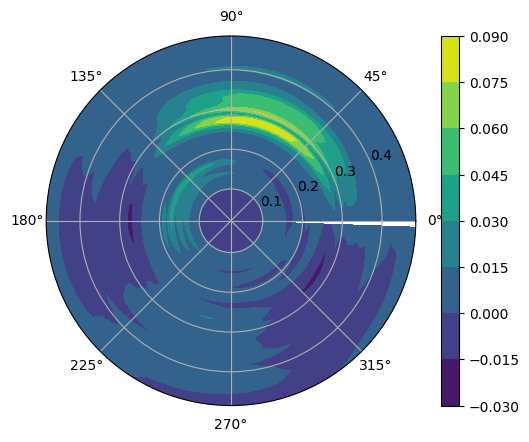

In [11]:
a,f = np.meshgrid(np.deg2rad(spectrum.direction), spectrum.frequency)
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
c = ax.contourf(a, f, spectrum)
# ax.contourf(a, f, spread)
# ax.contourf(np.random.random([nfreq, ndir]))
# plt.show()
plt.colorbar(c)